In [1]:
import os
import pandas as pd
import numpy as np
import torch
import random
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToPILImage
from tqdm import tqdm



In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True


In [3]:

# 학습에 사용할 장치를 설정합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 설정
data_path = '../data/'

In [4]:
# 학습 설정
img_size = 224  # 변경된 이미지 사이즈
#LR = 1e-3
#EPOCHS = 5
#BATCH_SIZE = 8
num_workers = 0  # 일단 0으로 설정하여 멀티프로세싱 비활성화
#early_stopping_patience = 5  # Early Stopping 설정
augment_ratio = 1


In [5]:

# 데이터 변환 설정
trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 800.0), p=0.75),
        A.GaussianBlur(blur_limit=(1, 7), p=0.5)
    ], p=0.75),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.75),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.25),
    A.CoarseDropout(max_holes=6, max_height=32, max_width=32, p=0.5),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Rotate(limit=30, p=0.75),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
    A.MotionBlur(blur_limit=5, p=0.5),
    A.OpticalDistortion(p=0.5),
    A.Transpose(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [29]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToPILImage
from tqdm import tqdm
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, augment_ratio=1):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.augment_ratio = augment_ratio

    def __len__(self):
        return len(self.df) * self.augment_ratio

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        name, target = self.df[real_idx]
        img_path = os.path.join(self.path, name)
        
        try:
            img = np.array(Image.open(img_path))
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = np.zeros((img_size, img_size, 3), dtype=np.uint8)  # 빈 이미지로 대체
        
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

    def save_original_images(self, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        all_data = []
        
        for idx, (name, target) in enumerate(self.df):
            img_path = os.path.join(self.path, name)
            try:
                img = Image.open(img_path)
                new_img_path = os.path.join(save_dir, f"original_{idx}.png")
                img.save(new_img_path)
                all_data.append([f"original_{idx}.png", target])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        
        # Save labels for original images
        labels_df = pd.DataFrame(all_data, columns=["filename", "label"])
        if os.path.exists(os.path.join(save_dir, "combined_labels.csv")):
            existing_labels = pd.read_csv(os.path.join(save_dir, "combined_labels.csv"))
            combined_df = pd.concat([existing_labels, labels_df], ignore_index=True)
        else:
            combined_df = labels_df
        
        combined_df.to_csv(os.path.join(save_dir, "combined_labels.csv"), index=False)

    def save_augmented_images(self, save_dir, augment_ratio=1):
        os.makedirs(save_dir, exist_ok=True)
        all_data = []

        # Save original images and labels
        self.save_original_images(save_dir)
        
        # Save augmented images
        num_images = len(self.df) * augment_ratio
        for idx in tqdm(range(num_images), desc="Saving augmented images"):
            real_idx = idx % len(self.df)
            name, target = self.df[real_idx]
            img_path = os.path.join(self.path, name)

            try:
                img = np.array(Image.open(img_path))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                img = np.zeros((img_size, img_size, 3), dtype=np.uint8)  # 빈 이미지로 대체

            if self.transform:
                img = self.transform(image=img)['image']

            # Save augmented image
            img_pil = ToPILImage()(img)  # Convert to PIL Image
            new_img_path = os.path.join(save_dir, f"augmented_{idx}.png")
            img_pil.save(new_img_path)

            # Save label information for augmented images
            all_data.append([f"augmented_{idx}.png", target])

        # Save all labels to a single CSV file
        labels_df = pd.DataFrame(all_data, columns=["filename", "label"])
        if os.path.exists(os.path.join(save_dir, "combined_labels.csv")):
            existing_labels = pd.read_csv(os.path.join(save_dir, "combined_labels.csv"))
            combined_df = pd.concat([existing_labels, labels_df], ignore_index=True)
        else:
            combined_df = labels_df
        
        combined_df.to_csv(os.path.join(save_dir, "combined_labels.csv"), index=False)


In [30]:

# 트레이닝 데이터셋 정의
trn_dataset = ImageDataset(
    f"{data_path}train.csv",
    f"{data_path}train/",
    transform=trn_transform,
    augment_ratio=augment_ratio
)

In [31]:
# 증강된 이미지 저장
save_dir = f"{data_path}augmented_train_data"
trn_dataset.save_augmented_images(save_dir, augment_ratio=augment_ratio)


Saving augmented images: 100%|██████████| 1570/1570 [00:36<00:00, 42.85it/s]


In [9]:
# 테스트 데이터셋 정의
tst_dataset = ImageDataset(
    f"{data_path}sample_submission.csv",
    f"{data_path}test/",
    transform=tst_transform,
    augment_ratio=1
)

In [10]:

# 원본 및 증강된 데이터 개수 출력
ori_traindata_num = int(len(trn_dataset) / augment_ratio)
print(f"Original training data count: {ori_traindata_num}")
print(f"Augmented training data count: {len(trn_dataset)}")
print(f"Test data count: {len(tst_dataset)}")


Original training data count: 1570
Augmented training data count: 1570
Test data count: 3140


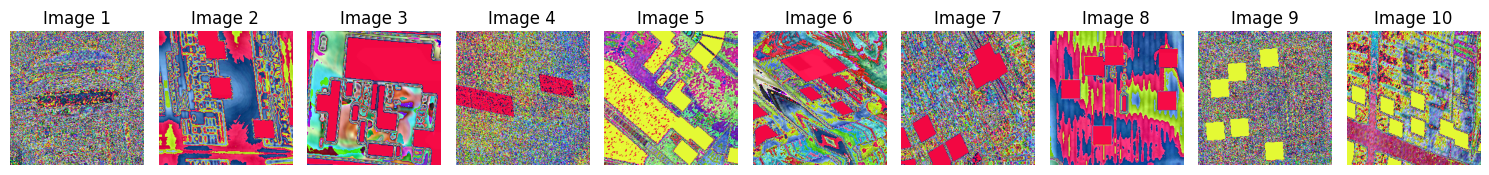

In [12]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def visualize_augmented_images(save_dir, num_images=5):
    # 저장된 이미지 파일 리스트 가져오기
    image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]
    
    # 시각화할 이미지 수 제한
    num_images = min(num_images, len(image_files))
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        img_path = os.path.join(save_dir, image_files[i])
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# 증강된 이미지 시각화
save_dir = f"{data_path}augmented_train_data"
visualize_augmented_images(save_dir, num_images=10)
